### High-concentration water on shelf

Look at HCW calculated as transport of water with tracer concentration higher or equal that threshold across shelf and canyon lid. The threshold is the tracer concentration at shelf break depth.


In [1]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns

import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [2]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('notebook')


In [3]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

In [4]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [5]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [37]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 150.0 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the hability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Rw(U=0.37,f=9.66E-5,Wsb=13000.0): 
    '''Rossby number using width at shelf break as length scale'''
    return(U/(f*Wsb))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,f=9.66E-5,L=6400,R=5000.0,Wsb=13000,N=0.0055):
    ''' flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    #f2 = (0.9**(1.5))*((Ro(U,f,R))/(1+(Ro(U,f,R)/0.9)))**(1.5)
    #f3 = Ro(U,f,L)**(0.5)
    f2=1.2*((U**3)*Wsb*L**(0.5))/(N*f*R**(3/2))
    return(f2)

In [22]:
# Save HCW at each 1/2 day into class record.

for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr2') 
    
    record.HCW = mtt.calc_HCW(Tr, MaskCNoC, rA, hFacCNoC, drF[:], nzlim=28, yin=227, xin=0, xfin=359, zfin=30, xi=180, yi=50)
    

tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766


In [32]:
# Save HCW at each 1/2 day into class record.

for record in recordsNoC:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr2') 
    
    record.HCW = mtt.calc_HCW(Tr, MaskCNoC, rA, hFacCNoC, drF[:], nzlim=28, yin=227, xin=0, xfin=359, zfin=30, xi=180, yi=50)
    

tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766
tracer limit concentration is:  7.03766


In [33]:
# get shelf volume (box sitting over shelf using NoC bathymetry)
ShVol = mtt.calc_ShelfVolume(rA[:,:], hFacCNoC[:,:,:], drF[:], yin=227, zfin=29)
print(ShVol)

253463579347.0


### HCW on shelf

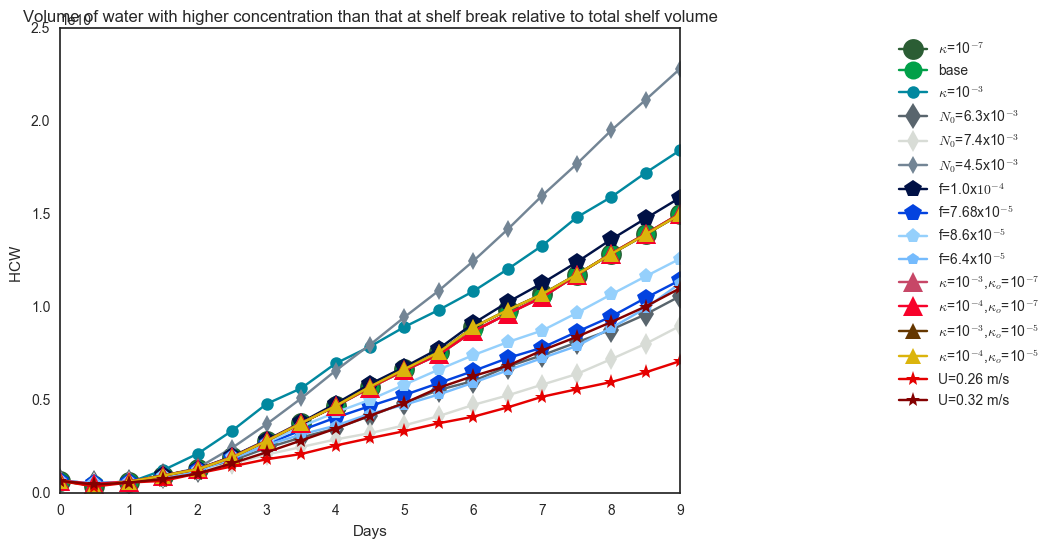

In [49]:
# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records,recordsNoC):
    
    plt1 = ax.plot(time[:]/(3600*24),recNoC.HCW,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Volume of water with higher concentration than that at shelf break relative to total shelf volume')
    ax.set_ylabel('HCW ')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



### Upwelling flux comparison to AH2010 

To calculate the upwelling flux from the HCW measurement we will subtract the volume of HCW a little bit after the beginning of the advective phase (day 5) from that at the end of the simulation (day 9) and divide by the time between them:

$\Phi = \frac{V_{HCW}(t_2)-V_{HCW}(t_1)}{t_2-t_1}$.

This was too noisy and depended a lot on which days I chose. So, I will calclulate the flux every half day and average it over the advective phase.

$\Phi = \frac{1}{N}(\sum_{ii=5}^{N-1}\frac{V_{HCW}(ii+1)-V_{HCW}(ii)}{t_{ii+1}-t_{ii}})$.

The scaling from AH2010 estimated the upwelling flux as:

$\Phi_{AH} = UW_{sb}Dh(\frac{0.9R_o}{1+R_o/0.9})^{3/2}R_L^{1/2} $

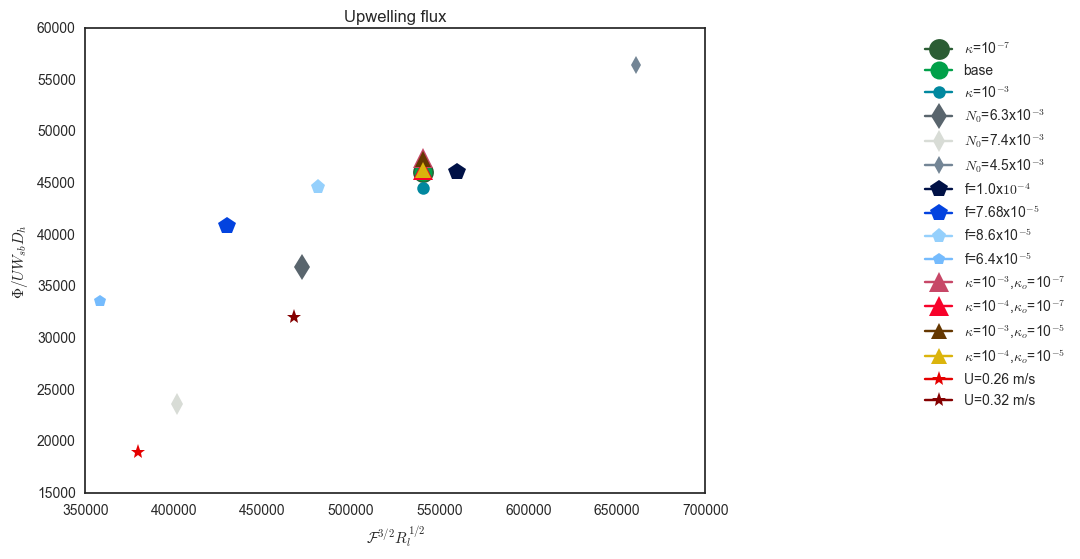

In [48]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07
    plt1 = ax.plot((rec.u*Wsb*Dh(rec.f,L,rec.N)),
                   ((rec.HCW[12]-rec.HCW[6])/(time[12]-time[6])),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Upwelling flux')
    ax.set_ylabel('$\Phi/UW_{sb}D_h$ ')
    ax.set_xlabel('$\mathcal{F}^{3/2}R_l^{1/2}$')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



In [10]:
record.name

'CNTDIFF_run64'

In [ ]:
1E-5